In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve



In [2]:
x=1
y=3
x+y

4

In [3]:
input_file2 = "/scratch/ys20884/ml_vars/TTToSemiLeptonic/df_ml_inputs.hd5"

with h5py.File(input_file2, "r") as f:
    print("Contents of the file:")
    for key in f.keys():
        print(key)

df2 = pd.read_hdf(input_file2, key="df")
print("Dataframe columns:")
print(df2.columns)


input_file4 = "/scratch/ys20884/ml_vars/ttH125/df_ml_inputs.hd5"

with h5py.File(input_file4, "r") as f:
    print("Contents of the file:")
    for key in f.keys():
        print(key)

df4 = pd.read_hdf(input_file4, key="df")
#print("Dataframe columns:")
#print(df4.columns)
print(len(df2))
print(len(df4))

Contents of the file:
df
Dataframe columns:
Index(['dataset', 'entry', 'BiasedDPhi', 'DiJet_mass', 'HT',
       'InputMet_InputJet_mindPhi', 'InputMet_phi', 'InputMet_pt', 'MHT_phi',
       'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'boostedObject_area', 'boostedObject_eta', 'boostedObject_mass',
       'boostedObject_phi', 'boostedObject_pt', 'boostedTop_area',
       'boostedTop_eta', 'boostedTop_mass', 'boostedTop_phi', 'boostedTop_pt',
       'boostedTop_tag', 'boostedV_area', 'boostedV_eta', 'boostedV_mass',
       'boostedV_phi', 'boostedV_pt', 'boostedV_tag', 'cleanedBJet_eta',
       'cleanedBJet_phi', 'cleanedBJet_pt', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_phi',
       'cleanedJet_pt', 'hashed_filename', 'ncleanedBJet', 'ncleanedJet',
       'weight_nominal', 'xs_weight'],
      dtype='object')
Contents of the file:
df
651387
177858


In [4]:
#df2 = pd.read_hdf(input_file2, key="df")
#df4 = pd.read_hdf(input_file4, key="df")

In [5]:
# This cell is going to implement so that only processes with 5 jets minimum are selected

# Create a boolean mask to filter for rows with 5 or more cleaned jets
mask_bg = df2['ncleanedJet'] >= 5
mask_signal = df4['ncleanedJet'] >= 5

# Use the mask to select the columns that meet the filter condition
filtered_bg = df2.loc[mask_bg]
filtered_signal = df4.loc[mask_signal]

# want to reset the index
filtered_bg = filtered_bg.reset_index(drop=True)
filtered_signal = filtered_signal.reset_index(drop=True)


In [6]:
print(len(df4))
print(len(filtered_bg), len(filtered_signal))

177858
388600 153571


In [7]:
print(f'{(len(df2) - len(filtered_bg) )/ len(df2)*100}% of data has been removed from background ')
print(f'There are now {len(filtered_bg)} events in background')
print(f'{(len(df4) - len(filtered_signal) )/ len(df4)*100}% of data has been removed from signal ')
print(f'There are now {len(filtered_signal)} events in background')

40.34268414936128% of data has been removed from background 
There are now 388600 events in background
13.655275556904947% of data has been removed from signal 
There are now 153571 events in background


In [8]:
# Change filtered_bg to df2 and filtered_signal to df4, so dont have to change 
# all accounts of this throughout the rest of the code

df2 = filtered_bg
df4 = filtered_signal


In [9]:
# make one big dataframe, 200000 long to practice with
df2 = df2[:100000]
df4 = df4[:100000]
df_total = df2.append(df4)
print(len(df_total))

# Background is 0
# Signal is 1
df_process = df_total['dataset']
df_total['dataset'] = df_total['dataset'].replace({'ttH125': 1, 'TTToSemiLeptonic': 0})
df_total.head()

#print(df_process)

200000


,dataset,entry,BiasedDPhi,DiJet_mass,HT,InputMet_InputJet_mindPhi,InputMet_phi,InputMet_pt,MHT_phi,MHT_pt,...,cleanedJet_eta,cleanedJet_mass,cleanedJet_neHEF,cleanedJet_phi,cleanedJet_pt,hashed_filename,ncleanedBJet,ncleanedJet,weight_nominal,xs_weight
0,0,46,2.162490,129.015341,466.076111,1.818359,2.597656,308.250,2.504940,339.473511,...,"[-0.5136719, -0.95703125, 0.48168945, -0.11907...","[24.203125, 17.90625, 12.1015625, 7.8515625, 7...","[0.013671875, 0.09667969, 0.171875, 0.12890625...","[-0.5839844, -1.3388672, 0.30273438, 0.7788086...","[158.16063, 141.62325, 66.15963, 60.8369, 39.2...",-5233776389657243962,1,5,1.377187e-06,0.000001
1,0,240,3.127692,256.094971,444.758789,0.022552,-1.201172,219.125,-1.537037,228.633820,...,"[0.2298584, 1.9931641, 0.8066406, 1.2314453, -...","[21.359375, 16.21875, 10.25, 7.5585938, 5.4492...","[0.08203125, 0.14648438, 0.1796875, 0.06103515...","[2.0839844, 1.6132812, -1.2236328, 0.1550293, ...","[182.53963, 85.12644, 69.15593, 68.64228, 39.2...",-5233776389657243962,1,5,7.287943e-07,0.000001
2,0,299,2.905946,580.818334,648.835327,0.474365,-0.402832,256.000,-0.473829,287.640656,...,"[0.84277344, -0.6044922, 1.4814453, -1.3603516...","[33.78125, 34.46875, 13.0859375, 10.3046875, 7...","[0.048828125, 0.12402344, 0.08496094, 0.077148...","[2.3886719, -0.8769531, 2.3066406, -2.1113281,...","[336.12476, 155.0912, 69.44901, 48.36236, 39.8...",-5233776389657243962,0,5,9.329514e-07,0.000001
3,0,422,2.619020,205.322889,704.391113,2.003906,1.114258,281.250,1.223088,319.017120,...,"[-0.10223389, -0.74560547, 0.21838379, -0.5053...","[18.3125, 28.359375, 24.375, 15.5, 12.875, 6.8...","[0.1796875, 0.061035156, 0.024902344, 0.122070...","[-0.8901367, -2.2441406, -1.7099609, -1.620117...","[168.69464, 125.064186, 118.458534, 93.086205,...",-5233776389657243962,1,8,1.132755e-06,0.000001
4,0,423,0.901701,328.267567,514.643127,1.107422,-0.027954,236.625,-0.095316,257.918945,...,"[1.6123047, 0.16394043, 1.4013672, 1.0810547, ...","[22.203125, 17.859375, 15.453125, 12.8671875, ...","[0.025390625, 0.30859375, 0.16210938, 0.029052...","[-3.109375, 1.0800781, -1.9160156, -2.8066406,...","[220.85329, 88.87581, 78.16917, 72.99306, 53.7...",-5233776389657243962,1,5,7.838240e-07,0.000001


In [10]:
print(len(df_total))

200000


In [11]:
df_weights = df_total['xs_weight']
df_total.drop(['entry', 'BiasedDPhi', 'hashed_filename', 'weight_nominal', 'xs_weight', 
              'InputMet_phi', 'MHT_phi', 'boostedObject_phi', 'boostedTop_phi', 'boostedV_phi',
              'cleanedBJet_phi','cleanedJet_phi'], axis=1, inplace=True)
df_total.columns            # Said BiasedDPhi looks wrong


Index(['dataset', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'boostedObject_area', 'boostedObject_eta', 'boostedObject_mass',
       'boostedObject_pt', 'boostedTop_area', 'boostedTop_eta',
       'boostedTop_mass', 'boostedTop_pt', 'boostedTop_tag', 'boostedV_area',
       'boostedV_eta', 'boostedV_mass', 'boostedV_pt', 'boostedV_tag',
       'cleanedBJet_eta', 'cleanedBJet_pt', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_pt', 'ncleanedBJet',
       'ncleanedJet'],
      dtype='object')

In [12]:
# Need to manipulate all features so that they are useable
# Cell to put data names into to see what max array and min array size are
# Should both be 1 if is to work
y = []
x = df_total['boostedObject_area']
for i in x:
    y.append(len(i))
print(min(y))
print(max(y))

0
2


In [13]:
print(df_total.columns  )


Index(['dataset', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'boostedObject_area', 'boostedObject_eta', 'boostedObject_mass',
       'boostedObject_pt', 'boostedTop_area', 'boostedTop_eta',
       'boostedTop_mass', 'boostedTop_pt', 'boostedTop_tag', 'boostedV_area',
       'boostedV_eta', 'boostedV_mass', 'boostedV_pt', 'boostedV_tag',
       'cleanedBJet_eta', 'cleanedBJet_pt', 'cleanedJet_area',
       'cleanedJet_btagDeepB', 'cleanedJet_chHEF', 'cleanedJet_eta',
       'cleanedJet_mass', 'cleanedJet_neHEF', 'cleanedJet_pt', 'ncleanedBJet',
       'ncleanedJet'],
      dtype='object')


In [14]:
# A function that makes arrays in rows singular values, max if multiple in array, 0 if empty array
def modify_array(arr):    
    if len(arr) == 0:
        return 0
    else:
    # takes leading jet    
        return max(arr)    #Need values as floats, not as arrays as NN did not accept arrays, needed as float
                            # If wanted arrays, put [] around returns, simple as that.

# e.g. df["column_name"] = df["column_name"].apply(modify_array)#
#e.g   df_total.boostedTop_area = df_total.boostedTop_area.apply(modify_array)

In [15]:
# This should have manipulated all data so is now fit for a ML model
for column in df_total:
    if df_total[column].dtype == 'object':
        df_total[column] = df_total[column].apply(modify_array)


In [16]:
X = df_total.copy()    
X.drop(['dataset'], axis = 1, inplace = True)   #Need to remove dataset (prediction) column
y = df_total['dataset']

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

input_shape = [X_train.shape[1]]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')
#print(len(x))
#print(len(y))
print(input_shape)

There are [33] variables in this model
The dataset has 200000 processes
[33]


In [17]:
#Define the Model

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape), 
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3), 
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),
    layers.Dense(units=1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)



Epoch 1/200
313/313 [==============================] - 13s 33ms/step - loss: 0.7009 - binary_accuracy: 0.6177 - val_loss: 0.6066 - val_binary_accuracy: 0.6709
Epoch 2/200
313/313 [==============================] - 12s 40ms/step - loss: 0.6170 - binary_accuracy: 0.6594 - val_loss: 0.5994 - val_binary_accuracy: 0.6738
Epoch 3/200
313/313 [==============================] - 13s 40ms/step - loss: 0.6090 - binary_accuracy: 0.6644 - val_loss: 0.5979 - val_binary_accuracy: 0.6746
Epoch 4/200
313/313 [==============================] - 14s 44ms/step - loss: 0.6029 - binary_accuracy: 0.6698 - val_loss: 0.5969 - val_binary_accuracy: 0.6763
Epoch 5/200
313/313 [==============================] - 14s 44ms/step - loss: 0.6004 - binary_accuracy: 0.6742 - val_loss: 0.5944 - val_binary_accuracy: 0.6778
Epoch 6/200
313/313 [==============================] - 15s 50ms/step - loss: 0.5993 - binary_accuracy: 0.6745 - val_loss: 0.5948 - val_binary_accuracy: 0.6784
Epoch 7/200
313/313 [=========================

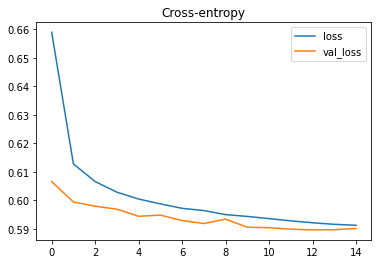

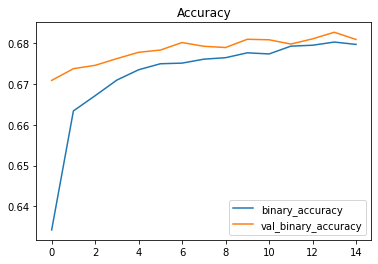

In [18]:
# Train the model

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    #verbose = 0   #Hide output of epochs
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))



In [19]:
# evaluate the model on the validation data
val_loss, val_acc = model.evaluate(X_valid, y_valid)    # do this for x_test and y_test and can compare
#print(len(X_valid))  #these are actually correct, 10k, test train split makes 4k test
#print(len(y_valid))
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid)
y_pred_round = np.round(y_pred)
#print(y_pred)

# # compute the confusion matrix
# cm = confusion_matrix(y_valid, y_pred_round)
# #print(cm)

# #cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm/(len(y_pred))*100) # now out of 100%
# disp.plot()
# # make so 200%, amount background correct 100% and amount signal correct 100%
# plt.show()

1250/1250 [==============================] - 7s 5ms/step - loss: 0.5906 - binary_accuracy: 0.6810
Validation loss: 0.590567409992218
Validation accuracy: 0.6810250282287598


[[0.75297544 0.24702456]
 [0.39030219 0.60969781]]


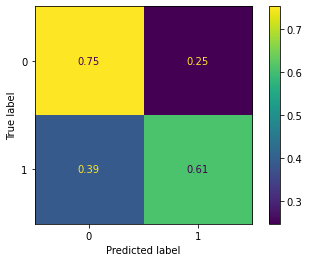

In [20]:
# compute the confusion matrix


cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm) # now out of 100%
disp.plot()
# make so 200%, amount background correct 100% and amount signal correct 100%
plt.show()

In [21]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.681025
True


In [22]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)
df

,True_Val,Predicted,Round Prediction
0,0,[0.49106607],[0.0]
1,1,[0.6403631],[1.0]
2,0,[0.89724594],[1.0]
3,1,[0.607863],[1.0]
4,0,[0.20871997],[0.0]
...,...,...,...
39995,1,[0.49561802],[0.0]
39996,1,[0.33732152],[0.0]
39997,0,[0.52907306],[1.0]
39998,1,[0.49347448],[0.0]


In [23]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.681025
True


In [24]:
# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df
#Can run cell above agai, after this one to check maintined order 

,True_Val,Predicted,Round Prediction
0,0,[0.49106607],[0.0]
22198,0,[0.47137463],[0.0]
22197,0,[0.51099885],[1.0]
22196,0,[0.45885128],[0.0]
22194,0,[0.3226609],[0.0]
...,...,...,...
6990,1,[0.5722398],[1.0]
25938,1,[0.25166833],[0.0]
11553,1,[0.32824343],[0.0]
25955,1,[0.818516],[1.0]


In [25]:
# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])


In [26]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print(ones_in_set)
print('The model predicted',pred_one-ones_in_set ,'more signal than in reality')
#so predicts like 3x less ones than are in set

pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print(zeros_in_set)
print('The model predicted', pred_zeros-zeros_in_set,'more background than in reality')


17166
20087
The model predicted -2921 more signal than in reality
22834
19913
The model predicted 2921 more background than in reality


now first half of df is background, other half is signal

PROBLEM, TEST AND VALID WAS SPLIT RANDOMLY, SO NOT ACTUALLY SAME AMOUNT OF 0's AND 1's

Not a problem, but need to check if should be like this

 A couple of options, I could:

Deal with it, and let there be uneven amounts of 1's and 0's

OR

Go back to test_train_split, and apply individually to signal and background and then sum them?

This would guarantee 50/50


In [27]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

#check no missing columns, if so out: True
len(df_bg)+len(df_signal) == len(df)

True

In [28]:
# Unneccessary, but check each type gives expected corrected and incorrect rate, to check that columns havent 
# Gotten messed up at all

lst_signal = []
for i in df_signal['Round Prediction']:
    if 1.0 == i:
        lst_signal.append(1)
    else:
        lst_signal.append(0)

#Below should == bottom rigtht of confusion matrix 
print(sum(lst_signal)/len(lst)*100) 

lst_bg = []
for i in df_bg['Round Prediction']:
    if 0.0 == i:
        lst_bg.append(1)
    else:
        lst_bg.append(0)

#Below should == top left of confusion matrix 
print(sum(lst_bg)/len(lst)*100) 

# SEE IS CORRECT SO ALL WORKING

30.617499999999996
37.485


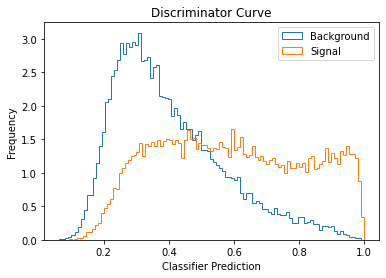

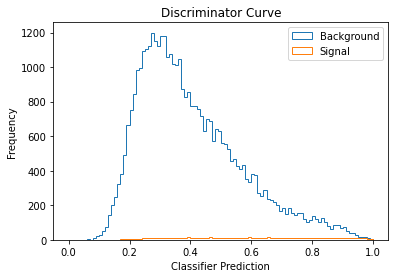

In [46]:
# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

#Unweighted
plt.hist(x= lst_of_values_bg_pred, bins=100, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=100, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be to proportion of full dataset too
#normalised
binwidth = 1/100    # want bins of 0.01                                                  # should still be 650k instead of 388600 and 177 instead of 153
plt.hist(x= lst_of_values_bg_pred, bins=np.arange(0, 1 + binwidth, binwidth),  weights = df2.xs_weight[:len(lst_of_values_bg_pred)]*3e5*(650000 /100000),
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=np.arange(0, 1 + binwidth, binwidth), weights = df4.xs_weight[:len(lst_of_values_signal_pred)]*3e5*(177000/100000),
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

#interesting see bins aren't algined
#


In [30]:
binwidth = 1/100
bins=np.arange(0, 1 + binwidth, binwidth)
bins

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

39878.886718034744
879.6134033277631


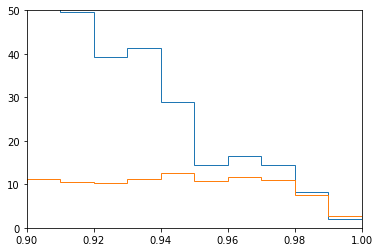

In [53]:
# tried to do the number of events without integrating, may have worked
binwidth = 1/100
n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=np.arange(0, 1 + binwidth, binwidth),  weights = df2.xs_weight[:len(lst_of_values_bg_pred)]*3e5*(650000 /100000),
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=np.arange(0, 1 + binwidth, binwidth), weights = df4.xs_weight[:len(lst_of_values_signal_pred)]*3e5*(177000/100000),
         histtype = 'step', label = 'Signal')

plt.xlim(0.9,1)
plt.ylim(0,50)
# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)



In [32]:

print( df4.xs_weight[1])
print( df2.xs_weight[1])

8.6958615e-08
1.0588149e-06


In [33]:
print(df_signal)

       True_Val     Predicted  Round Prediction
33015         1   [0.9376316]               1.0
3631          1   [0.9740436]               1.0
32749         1  [0.41246074]               0.0
3598          1   [0.8459314]               1.0
3750          1   [0.4436723]               0.0
...         ...           ...               ...
6990          1   [0.5722398]               1.0
25938         1  [0.25166833]               0.0
11553         1  [0.32824343]               0.0
25955         1    [0.818516]               1.0
19999         1   [0.9787519]               1.0

[20087 rows x 3 columns]


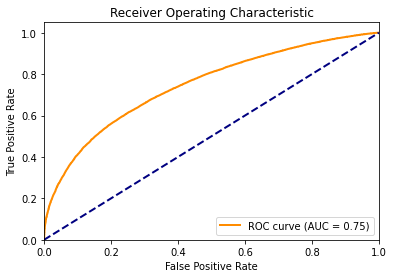

0.7462628361585173
16175


In [48]:
#plot ROC curves

y_true = df['True_Val']
y_score = df['Predicted']

# calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)  #79%

print(len(thresholds))



In [35]:
data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
df_roc = pd.DataFrame(data_roc)
df_roc

<ipython-input-35-66289c320eca>:1: RuntimeWarning: divide by zero encountered in divide
  data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
<ipython-input-35-66289c320eca>:1: RuntimeWarning: invalid value encountered in divide
  data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}


,thresholds,tpr,fpr,tpr/sqrt(fpr)
0,1.998741,0.000000,0.000000,NaN
1,[0.99874103],0.000050,0.000000,inf
2,[0.99061465],0.002589,0.000000,inf
3,[0.9905127],0.002589,0.000050,0.365306
4,[0.98641646],0.006074,0.000050,0.857064
...,...,...,...,...
16170,[0.110999554],0.999900,0.998493,1.000654
16171,[0.11036521],0.999950,0.998493,1.000704
16172,[0.09286514],0.999950,0.999598,1.000151
16173,[0.09206712],1.000000,0.999598,1.000201


In [36]:
df_roc.head(20)

,thresholds,tpr,fpr,tpr/sqrt(fpr)
0,1.998741,0.000000,0.000000,NaN
1,[0.99874103],0.000050,0.000000,inf
2,[0.99061465],0.002589,0.000000,inf
3,[0.9905127],0.002589,0.000050,0.365306
4,[0.98641646],0.006074,0.000050,0.857064
5,[0.986162],0.006074,0.000151,0.494826
6,[0.984668],0.007268,0.000151,0.592169
7,[0.9846406],0.007268,0.000201,0.512833
8,[0.9837368],0.007916,0.000201,0.558496
9,[0.9836991],0.007916,0.000251,0.499534


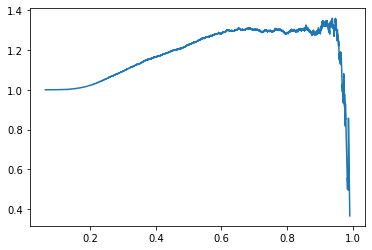

In [49]:
plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
plt.show()

In [38]:
max(df_roc['tpr/sqrt(fpr)'][3:])

1.3598543577116577

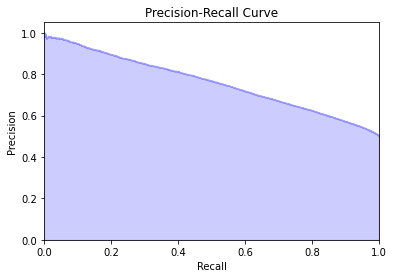

0.7603364222214858


In [50]:
# Plot precision recall curve
from sklearn.metrics import average_precision_score

y_true = df['True_Val']
y_score = df['Predicted']

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

AUC = average_precision_score(y_true, y_score)   #0.793, pretty similar to roc AUC
print(AUC)

In [40]:
df['True_Val']
x = df['Predicted']
print(x)

0        [0.49106607]
22198    [0.47137463]
22197    [0.51099885]
22196    [0.45885128]
22194     [0.3226609]
             ...     
6990      [0.5722398]
25938    [0.25166833]
11553    [0.32824343]
25955      [0.818516]
19999     [0.9787519]
Name: Predicted, Length: 40000, dtype: object


# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

In [41]:
# Idea to create a sweeping function, doesn't work but good idea, do much more easily.

def find_best_threshold(df, column):
    # Initialize variables to store the best threshold and the corresponding Z-score
    best_threshold = 0
    best_z = 0
    
    # Loop through all possible threshold values
    for threshold in np.arange(0, 1, 0.01):
        # Count the number of signal and background events above the threshold
        signal = df.query(f"{column} >= {threshold}").shape[0]
        background = df.query(f"{column} < {threshold}").shape[0]
        
        # Calculate the Z-score
        z = signal / np.sqrt(background)
        
        # Update the best threshold and Z-score if a higher value is found
        if z > best_z:
            best_threshold = threshold
            best_z = z
    
    return best_threshold


39878.886718034744
879.6134033277631


<ipython-input-54-93c52e230798>:22: RuntimeWarning: invalid value encountered in double_scalars
  z_i = num_signal_events / np.sqrt(num_bg_events)


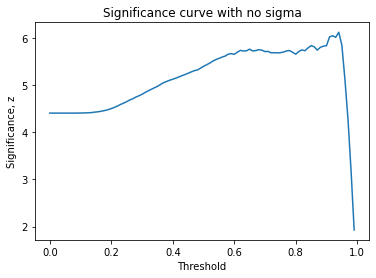

94
6.11899169993434


In [54]:
# Easier Idea

# binwidth = 1/100
# n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=np.arange(0, 1 + binwidth, binwidth),
#                                      weights = df2.xs_weight[:len(lst_of_values_bg_pred)]*3e5*(651387/100000),
#          histtype = 'step', label = 'Background')
# n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=np.arange(0, 1 + binwidth, binwidth),
#                                                  weights = df4.xs_weight[:len(lst_of_values_signal_pred)]*3e5*(177858/100000),
#          histtype = 'step', label = 'Signal')
# plt.show()
# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    z_i = num_signal_events / np.sqrt(num_bg_events)
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
print(index_of_max)
print(max_value)

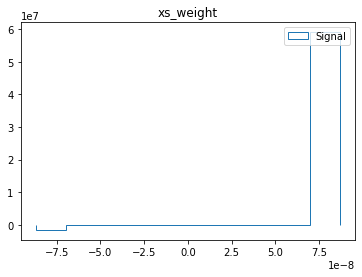

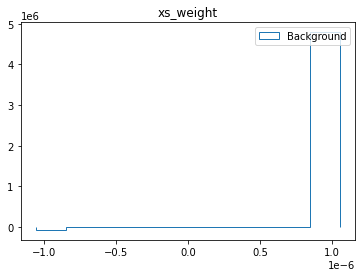

In [43]:
# See weight is const basically, so just use a value

semi_xs_weight = df2['xs_weight']   # plot to show is wrong, at least 1 -ive val (is this right?)
signal_xs_weight = df4['xs_weight'] 
#plt.hist(x=semi_xs_weight, bins = 10, weights = df2.xs_weight, density = True, histtype = 'step', label = 'Background')
plt.hist(x=signal_xs_weight, bins = 10, weights = df4.xs_weight, density = True, histtype = 'step', label = 'Signal')
plt.title('xs_weight')
plt.legend()
plt.show() 

semi_xs_weight = df2['xs_weight']   # plot to show is wrong, at least 1 -ive val (is this right?)
signal_xs_weight = df4['xs_weight'] 
plt.hist(x=semi_xs_weight, bins = 10, weights = df2.xs_weight, density = True, histtype = 'step', label = 'Background')
#plt.hist(x=signal_xs_weight, bins = 10, weights = df4.xs_weight, density = True, histtype = 'step', label = 'Signal')
plt.title('xs_weight')
plt.legend()
plt.show() 

In [44]:
#Also, to make sure we get the event weights correct, can each of you try and produce a number for the 
#total number of events you obtain when using all events in the ttH125 and ttbar semileptonic dataframes,
#normalized to 300/fb?
#Hopefully you all arrive at the same result.

# Sligthly confused, does x_s weight normalised already entail no. events,
# So xs_weight * 300,000 is no events

#Or

# Are we meant to use the equation you showed us last week and work out what N should be

#Or

# do both and compare them as should be same?

bg_weight = semi_xs_weight[1]
signal_weight = signal_xs_weight[1]

# total number SL
sl_tot_events = bg_weight * 300000      # weight per pb to 300fb

# total number signal
signal_tot_events = signal_weight * 300000

print('Total number of semileptonic events is {}'.format(sl_tot_events))
print('Total number of ttH125 events is {}'.format(signal_tot_events))
print()

sl_events = 300000 * 500
signal_events = 300000 * 0.5

print('Total number of semileptonic events is {}'.format(sl_events)) #150000k
print('Total number of ttH125 events is {}'.format(signal_events))   #150k
#tot_events = 

Total number of semileptonic events is 0.3176444579366944
Total number of ttH125 events is 0.02608758435940217

Total number of semileptonic events is 150000000
Total number of ttH125 events is 150000.0


# Q 
Can you also overlay the discriminator distributions for the test data 
(normalized to the same area) to check if training and testing samples agree?
# A
not sure what is meant, so show code for the one that I did do. I did it for validation data, so when he says this does hr mean my data is test or training

# Q 
If you use all the events in the dataframes and weight each entry by xs_weight you should
get the expected number of events for 1 /pb. Is everything in the plot below already 
multiplied by 300000 to get the event yields expected for 300/fb?
What exactly did you use?

# A
Yes, everything in the weighted plot is multiplied by 300000, show what I used as I am not sure if thats right

# Q
If you integrate the weighted histograms, how many events do you obtain in each histogram? 

# A
Bit confused, why integrate the histograms when can just see how much data used, is it because this is weighted so it will give the number of events we actually expect overall in 300000 fb^-1, makes sense.
#Did 3 ways, not really clear what was right, way I think rn is each bin is a number of events, so just need to add number events per bin, dont need to do anything regarding the width of the bin? But then an integral is the area so that does mean bin size matters, but not really sure, bc obvs sum bin size = 1
#Think first one is correct


# Q 
Next would be to plot ROC curves and precision-recall which have slightly different meaning.

# A
So does a ROC curve work out where the best threshold is for us, so what is significance. Also should a ROC curve be weighted

# Q 
from the weighted plot, make a plot of Z = S/sqrt(B) as a function of the cut on the discriminator value, where S and B are the number of events (i.e. the integral) of the histogram 
that have discriminator value above the cut you chose. You may need to “zoom in” on the region >0.9 
to see that it falls off again as you approach 1

In [45]:
# 